In [2]:
import pickle
import random

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.keras as tfk
from exploration_model import Explorer
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

sns.set(
    context="talk",
    style="ticks",
    font="Arial",
    font_scale=1.0,
    rc={"svg.fonttype": "none", "lines.linewidth": 1.5, "figure.autolayout": True},
)

# Data formatting

In [3]:
data = pickle.load(open("data/fp_weights_space.p", "rb"))

In [4]:
class ChemicalSpace:
    """
    class to manage the simulated chemical space. It keeps track of experiments that
    have been seen or unseen by the algorithm.
    methods:
    random_guess: assign a random percentage to the seen reactions
    update_explored_indexes: assign the selected indexes to the seen reactions
    update_df: based on seen/unseen indexes it splits the complete dataset
    accordingly
    """

    def __init__(self, dic, seed=None):
        random.seed(seed)

        self.FULLreagent_fps = dic["reagent_fps"]
        self.FULLreactant_mat = dic["reactant_mat"]
        self.FULLpredictions = dic["predictions"]
        self.FULLsample_weights = dic["sample_weights"]

        self.unseen = list(range(len(self.FULLreagent_fps)))
        self.seen = []
        self.space_len = len(self.unseen)

        random.shuffle(self.unseen)

    def random_guess(self, percent):
        num_of_rxns = int(self.space_len * percent)
        random_idxs = []

        for idx in self.unseen:
            self.seen.append(idx)
            random_idxs.append(idx)
            if len(random_idxs) == num_of_rxns:
                break
        for idx in random_idxs:
            self.unseen.remove(idx)

        self.update_df()

    def update_explored_indexes(self, indexes):
        for idx in indexes:
            self.seen.append(idx)
            self.unseen.remove(idx)
        self.update_df()

    def update_df(self):
        self.reagent_fps = self.FULLreagent_fps.take(self.seen, axis=0)
        self.reactant_mat = self.FULLreactant_mat.take(self.seen, axis=0)
        self.predictions = self.FULLpredictions.take(self.seen, axis=0)
        self.sample_weights = self.FULLsample_weights.take(self.seen, axis=0)

        self.Ureagent_fps = self.FULLreagent_fps.take(self.unseen, axis=0)
        self.Ureactant_mat = self.FULLreactant_mat.take(self.unseen, axis=0)
        self.Upredictions = self.FULLpredictions.take(self.unseen, axis=0)
        self.Usample_weights = self.FULLsample_weights.take(self.unseen, axis=0)


class Simulation:
    """
    class used for the simulated exploration of the chemical space. It trains the
    neural netowork on pregressively bigger datasets and tries to explore the space
    performing the reactive combinations first.
    """

    def __init__(self, data, seed=147):
        self.data = data
        self.chemspace = ChemicalSpace(data, seed=seed)
        self.random_percent = 0.1
        self.model = Explorer()
        self.results = []

    def explore_space(self):
        # defines the batch size for exploration of chemical space
        screen_size = 50
        # randomly guess select 10 % of chemical space
        self.chemspace.random_guess(self.random_percent)

        # keep statistics for plotting
        rxn = [0.5 * len(self.chemspace.seen)]
        width = [0.95 * len(self.chemspace.seen)]
        self.results.append([i for i in self.chemspace.predictions])

        # Evaluate average yield of selected reactions
        avg_real_yield = [np.mean(self.chemspace.predictions)]
        # Evaluate standard deviation
        stds = [np.std(self.chemspace.predictions)]

        iteration = 0

        while not len(self.chemspace.unseen) == 0:
            # Add data to plot
            if iteration == 0:
                rxn.append(2 * rxn[-1] + 0.5 * screen_size)
            else:
                if len(self.chemspace.unseen) < screen_size:
                    screen_size = len(self.chemspace.unseen)
                rxn.append(rxn[-1] + screen_size)

            width.append(0.95 * screen_size)

            # train neural network with seen data
            print(f"training on {len(self.chemspace.seen)}")
            self.model.train(
                self.chemspace.reagent_fps,
                self.chemspace.reactant_mat,
                self.chemspace.predictions,
                self.chemspace.sample_weights,
            )

            # assign reactivity to unseen data
            self.yp = self.model.test(
                self.chemspace.Ureagent_fps, self.chemspace.Ureactant_mat
            )

            # Sort the dataframe by predicted yield
            unseen_df = pd.DataFrame(
                {
                    "prediction": self.yp,
                    "indexes": self.chemspace.unseen,
                    "real_react": self.chemspace.Upredictions,
                }
            )
            sorted_by_prediction = unseen_df.sort_values(
                by=["prediction"], ascending=False
            )
            # Get a dataframe with best candidates from prediction
            self.best_results = sorted_by_prediction.head(screen_size)
            # Get idxs of best candidates
            best_results_idxs = list(self.best_results["indexes"])
            # Evaluate real yiled of selected batch of reactions
            avg_real_yield.append(np.mean(self.best_results["real_react"]))
            # Calcuate and print the standard deviation for current batch of reactions
            stds.append(np.std(self.best_results["real_react"]))
            self.results.append([i for i in self.best_results["real_react"]])
            # Add the current batch of reactions to explored reactions so in
            # the next iteration neural network can be trained on updated data
            self.chemspace.update_explored_indexes(best_results_idxs)
            iteration += 1

        return rxn, avg_real_yield, stds, width, self.results

# Testing

In [5]:
sim = Simulation(data, seed=29)

D:\Users\Uigedail\mambaforge\envs\Rx1st\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|                                                                                                             | 0/5 [00:00<?, ?it/s]


AtomKekulizeException: non-ring atom 2 marked aromatic

In [14]:
rxn, avg_real_yield, stds, width, results = sim.explore_space()

training on 101
Restoring model weights from the end of the best epoch.
Epoch 00096: early stopping
training on 151
Restoring model weights from the end of the best epoch.
Epoch 00142: early stopping
training on 201
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
training on 251
Restoring model weights from the end of the best epoch.
Epoch 00139: early stopping
training on 301
Restoring model weights from the end of the best epoch.
Epoch 00075: early stopping
training on 351
Restoring model weights from the end of the best epoch.
Epoch 00157: early stopping
training on 401
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
training on 451
Restoring model weights from the end of the best epoch.
Epoch 00110: early stopping
training on 501
Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
training on 551
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping


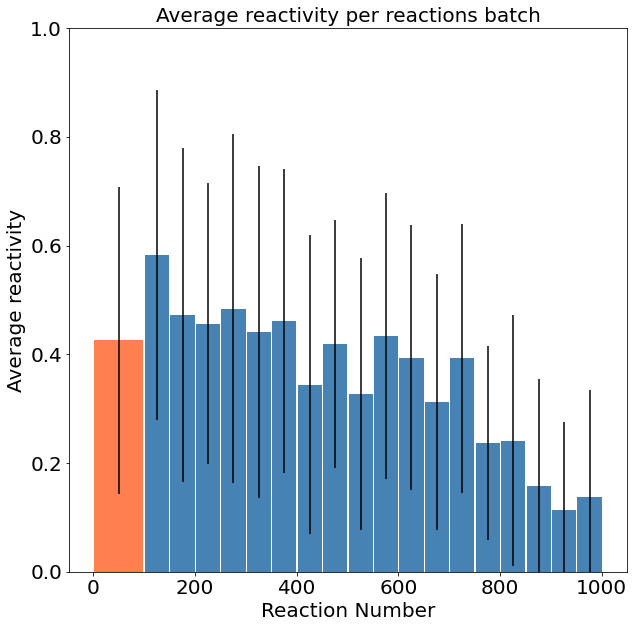

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure(figsize=(10, 10))
colors = ["steelblue" for i in range(20)]
colors[0] = "coral"
plt.bar(
    rxn[:-1],
    avg_real_yield[:-1],
    yerr=stds[:-1],
    width=width[:-1],
    color=colors[:-1],
)
plt.title("Average reactivity per reactions batch", fontsize=20)
plt.xlabel("Reaction Number", fontsize=20)
plt.ylabel("Average reactivity", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0, 1)
plt.show()
plt.savefig("explorations/" + str(2) + ".svg")

# Correlation plot

In [3]:
model = Explorer()

reagent_fps = data["reagent_fps"]
reactant_mat = data["reactant_mat"]
predictions = data["predictions"]
sample_weights = data["sample_weights"]

/home/group/mambaforge/envs/jtnn_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 20%|██        | 1/5 [00:02<00:10,  2.70s/it]RDKit WARNING: [18:31:07] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:31:07] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


In [7]:
model = tfk.models.load_model("data/reactivity_models/best_model_exploration")
(
    reagent_fps_train,
    reagent_fps_test,
    reactant_mat_train,
    reactant_mat_test,
    pred_train,
    pred_test,
    weights_train,
    weights_test,
) = train_test_split(
    reagent_fps,
    reactant_mat,
    predictions,
    sample_weights,
    test_size=0.2,
    random_state=39,
)
output = model([reagent_fps_test, reactant_mat_test]).numpy().flatten()

In [8]:
df = pd.DataFrame({"expected": output, "predicted": pred_test})

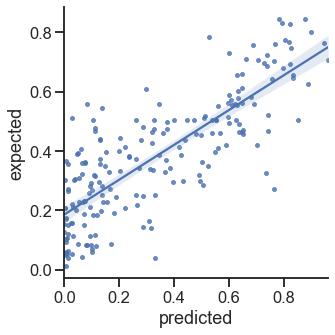

In [9]:
f = sns.lmplot(
    data=pd.DataFrame({"expected": output, "predicted": pred_test}),
    y="expected",
    x="predicted",
    legend=False,
    aspect=1,
    scatter_kws={"s": 15.0},
)